# Banknote serial number recognition

A system for banknote serial number recognition.

## Prerequsites

#### Importing modules

In [1]:
import os
import re
import glob

import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

tf.__version__

'2.1.0'

#### Configuration

In [2]:
train_locations = [
    "./dataset/SNRdataset/EUR/train",
    "./dataset/SNRdataset/JPY_1K_5K/train",
    "./dataset/SNRdataset/JPY_2K_10K/train",
    "./dataset/SNRdataset/KRW/train"
]

test_locations = [
    "./dataset/SNRdataset/EUR/val",
    "./dataset/SNRdataset/JPY_1K_5K/test",
    "./dataset/SNRdataset/JPY_2K_10K/test",
    "./dataset/SNRdataset/KRW/test"
]

## Exploring image data

#### Loading data
Going through every directory in the dataset and loading all the images into numpy arrays using Pillow.

In [3]:
def load_data(locations: str):
    data = []
    for location in locations:
        for path in glob.glob(location + "/*"):
            image = np.array(Image.open(path), dtype=np.uint8)
            serial = os.path.splitext(os.path.basename(path))[0].split('_')[-1].replace('z', '')
            data.append({"image": image, "serial": serial})

    return data

In [4]:
train_data = load_data(train_locations)
test_data = load_data(test_locations)

#### Preview a subset of the data
Plotting a random subset of 25 serial number images and their labeling to verify if they are loaded properly.

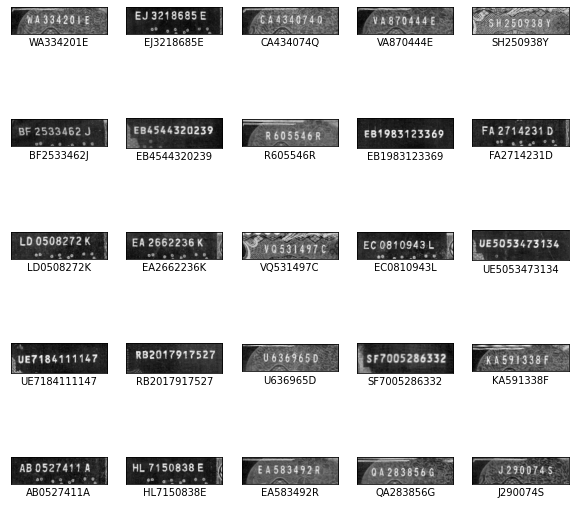

In [5]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image_index = random.randint(0, len(train_data))
    plt.imshow(train_data[image_index]["image"], cmap=plt.cm.binary)
    plt.xlabel(train_data[image_index]["serial"])
plt.show()